In [140]:
from numpy import ones, linspace, sqrt, concatenate, asarray, inf
from numpy_sugar import ddot
from numpy.random import RandomState
from numpy_sugar.linalg import economic_qs, economic_qs_linear, economic_svd
from glimix_core.lmm import LMM

In [395]:
from cellregmap import CellRegMap, run_association, run_association_fast, run_interaction, estimate_betas

In [97]:
random = RandomState(1)
n = 30                               # number of samples (cells)
p = 5                                # number of individuals
k = 4                                # number of contexts
y = random.randn(n, 1)               # outcome vector (expression phenotype, one gene only)
C = random.randn(n, k)               # context matrix (cells by contexts/factors)
W = ones((n, 1))                     # intercept (covariate matrix)
hK = random.randn(n, p)              # decomposition of kinship matrix (K = hK @ hK.T)
g = 1.0 * (random.rand(n, 1) < 0.2)  # SNP vector

In [98]:
import time
import matplotlib.pyplot as plt

In [99]:
########################################################
########################################################
########################################################

In [100]:
########################################################
############## Association Test

In [101]:
###### Fit null model
# crm = CellRegMap(y=y, W=W, C=C, hK=hK)

In [148]:
start_time = time.time()
rhos = linspace(0, 1, 11)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0002543926239013672 seconds ---


In [149]:
rhos

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [150]:
# pick one value of rho as example

In [547]:
rho = rhos[0]
rho

0.0

In [548]:
a = sqrt(rho)
b = sqrt(1 - rho)
[a,b]

[0.0, 1.0]

In [549]:
start_time = time.time()
hS = concatenate([a * C] + [b * hK], axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00027680397033691406 seconds ---


In [550]:
# plt.matshow(hS)

In [551]:
# plt.matshow(hS @ hS.T)

In [552]:
# just checking this is the same
# M = rho*C @ C.T + (1-rho)*(hK @ hK.T)
# plt.matshow(M)

In [553]:
# rank = 9: 4 contexts + 5 individuals
# n cells = 30
hS.shape

(30, 9)

In [554]:
S = hS @ hS.T
S.shape

(30, 30)

In [555]:
start_time = time.time()
QS = economic_qs_linear(hS, return_q1=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0003991127014160156 seconds ---


In [556]:
# eigenvectors
# Q = QS[0][0]
# Q.shape

In [557]:
# eigenvalues
# L = QS[1]
# L.shape

In [558]:
# plt.matshow(Q)

In [559]:
###### Run association for specified genotypes
# crm.scan_association_fast(g)

In [560]:
# again looping over rhos, 
# for each row load the corresponding QS computed before
# here just using for rho=0.3 as above

In [561]:
start_time = time.time()
lmm = LMM(y, W, QS, restricted=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0006306171417236328 seconds ---


In [562]:
start_time = time.time()
lmm.fit(verbose=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007986307144165039 seconds ---


In [563]:
# let us pretend this is the best lmm (i.e. this value of rho corresponds to max likelihood value)

In [564]:
start_time = time.time()
null_lmm = lmm
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00011658668518066406 seconds ---


In [565]:
start_time = time.time()
flmm = lmm.get_fast_scanner()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005817413330078125 seconds ---


In [566]:
start_time = time.time()
alt_lmls = flmm.fast_scan(g, verbose=False)['lml']
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0023317337036132812 seconds ---


In [567]:
def lrt_pvalues(null_lml, alt_lmls, dof=1):
    from numpy import clip
    from numpy_sugar import epsilon
    from scipy.stats import chi2

    lrs = clip(-2 * null_lml + 2 * asarray(alt_lmls, float), epsilon.super_tiny, inf)
    pv = chi2(df=dof).sf(lrs)
    return clip(pv, epsilon.super_tiny, 1 - epsilon.tiny)

In [568]:
start_time = time.time()
pvalues = lrt_pvalues(null_lmm.lml(), alt_lmls, dof=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0016846656799316406 seconds ---


In [569]:
pvalues

array([0.74595695])

In [546]:
## compared to association runner
run_association(y=y, W=W, E=C, hK=hK, G=g)[0]

100%|██████████| 1/1 [00:00<00:00, 95.49it/s]


array([0.74236452])

In [520]:
## compared to association runner (fast)
run_association_fast(y=y, W=W, E=C, hK=hK, G=g)[0]

array([0.74855415])

In [521]:
## compared to two steps association (fast) - identical to this one
crm = CellRegMap(y=y, W=W, E=C, hK=hK)
crm.scan_association_fast(g)[0]

array([0.74595695])

In [522]:
# not fast
crm.scan_association(g)[0]

100%|██████████| 1/1 [00:00<00:00, 109.10it/s]


array([0.74594644])

In [ ]:
########################################################
########################################################
########################################################

In [ ]:
########################################################
############## Interaction Test

In [ ]:
###### get L values
# Ls = get_L_values(hK, C)

In [69]:
start_time = time.time()
[U, S, _] = economic_svd(C)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00045037269592285156 seconds ---


In [70]:
U.shape

(30, 4)

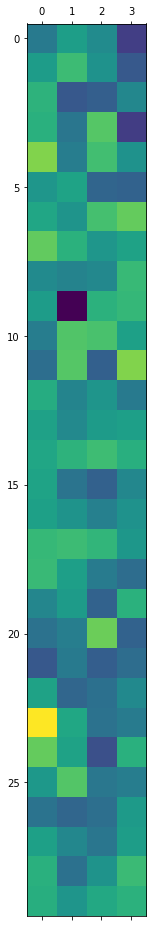

In [73]:
plt.matshow(U)

In [71]:
S.shape

(4,)

In [75]:
start_time = time.time()
us = U * S
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00011444091796875 seconds ---


In [78]:
start_time = time.time()
Ls = [ddot(us[:,i], hK) for i in range(us.shape[1])]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0004088878631591797 seconds ---


In [80]:
# one per context
len(Ls)

4

In [82]:
# n cells X n individuals
Ls[0].shape

(30, 5)

In [ ]:
###### Fit null model
# crm = CellRegMap(y=y, W=W, C=C, Ls=Ls)

In [83]:
# rhos, a, b as above

In [84]:
start_time = time.time()
hS = concatenate([a * C] + [b * L for L in Ls], axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005128383636474609 seconds ---


In [86]:
# rank = 24: 4 contexts + (5 individuals)*4
# n cells = 30
hS.shape

(30, 24)

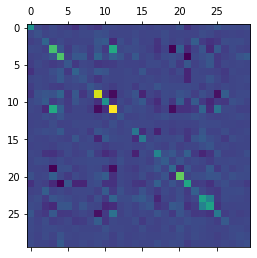

In [85]:
plt.matshow(hS @ hS.T)

In [87]:
start_time = time.time()
QS = economic_qs_linear(hS, return_q1=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00055694580078125 seconds ---


In [88]:
# eigenvectors
Q = QS[0][0]
Q.shape

(30, 24)

In [89]:
# eigenvalues
L = QS[1]
L.shape

(24,)

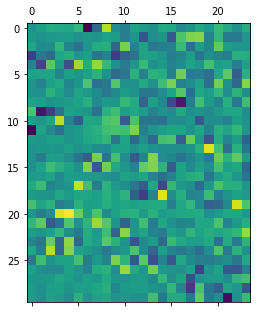

In [90]:
plt.matshow(Q)

In [ ]:
###### Run GxC interaction for specified genotypes
# crm.scan_interaction(g)